# **02 - Naive Baseline Models**

This notebook creates simple baseline forecasts for realized volatility. These baselines help establish a reference level of performance. Any advanced model should exceed these benchmarks in a measurable way.

Realized volatility used here is `rv_21`, computed earlier and saved in `modeling_dataset.csv`.  <br>
This notebook trains baselines on the training segment and evaluates them on the held out test period.

## **Objectives**

* Implement a persistence model.
* Implement rolling mean models with window sizes that represent short, medium, and slightly longer memory.
* Implement a global mean baseline.
* Use a clear time-based split.
* Evaluate with RMSE and MAE.
* Save forecasts and metrics for later comparison.

## **Notebook Outputs**

* `baseline_forecasts.csv`
* `baseline_metrics.csv`
* `baseline_forecasts.png`

The files are saved in the `results` folder.

## **Load Data**

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("seaborn-v0_8")

# Load processed dataset
data_path = Path("../data/processed/modeling_dataset.csv")
df = pd.read_csv(data_path)
df["Date"] = pd.to_datetime(df["Date"])

df = df.sort_values("Date").reset_index(drop=True)

print(df.head(), "\n")
print(df.tail(), "\n")
print(df.isna().sum())

target_col = "rv_21"


        Date         Open         High  ...      Volume  log_return     rv_21
0 2000-02-02  1409.280029  1420.609985  ...  1038600000   -0.000114  0.016190
1 2000-02-03  1409.119995  1425.780029  ...  1146500000    0.011185  0.013915
2 2000-02-04  1424.969971  1435.910034  ...  1045100000   -0.000421  0.013915
3 2000-02-07  1424.369995  1427.150024  ...   918100000   -0.000091  0.013916
4 2000-02-08  1424.239990  1441.829956  ...  1047700000    0.012198  0.012880

[5 rows x 9 columns] 

           Date         Open         High  ...      Volume  log_return     rv_21
6491 2025-11-21  6555.770020  6660.049805  ...  5929930000    0.009775  0.008980
6492 2025-11-24  6636.540039  6715.750000  ...  6039740000    0.015349  0.009482
6493 2025-11-25  6697.029785  6776.399902  ...  5003330000    0.009021  0.009290
6494 2025-11-26  6793.549805  6831.439941  ...  4485000000    0.006883  0.009418
6495 2025-11-28  6822.520020  6850.859863  ...  2558540000    0.005340  0.009506

[5 rows x 9 columns] 

## **Train-Test Split**

We use a simple time-based split with 80% of data for training. No shuffling is applied. This prevents leakage and keeps the evaluation reailstic.

In [32]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train = df.iloc[:split_index].copy()
test = df.iloc[split_index:].copy()

print("Train period: ", train["Date"].min(), "to", train["Date"].max())
print("Test period: ", test["Date"].min(), "to", test["Date"].max())
print("Test observations:", len(test))
print("Years of test data:", round(len(test) / 252, 2))

y_train = train[target_col].values
y_test = test[target_col].values
dates_test = test["Date"].values

Train period:  2000-02-02 00:00:00 to 2020-09-25 00:00:00
Test period:  2020-09-28 00:00:00 to 2025-11-28 00:00:00
Test observations: 1300
Years of test data: 5.16


## **Baseline Models**

We now construct the following baselines-
* Persistence: forecast tomorrow as today.
* Rolling mean with window 5.
* Rolling mean with window 10.
* Rolling mean with window 21.
* Global mean of the training set.

These baselines are simple but informative. They show how much structure an advanced model must capture to outperform naive strategies.

## Persistence Model

In [33]:
train["persistence"] = train[target_col].shift(1)
test["persistence"] = test[target_col].shift(1)

# First test forecast uses the last training value
test.loc[test.index[0],"persistence"] = train[target_col].iloc[-1]

## Rolling Mean Baselines

Rolling means are computed on the training segment. The final training rolling value is then used to forecast the entire test window. This keeps the procedure leak free.

In [34]:
for w in [5, 10, 21]:
    roll_name = f"roll_mean_{w}"
    train[roll_name] = train[target_col].rolling(w).mean()
    
    last_roll_value = train[roll_name].iloc[-1]
    test[roll_name] = last_roll_value


## Global Mean Baseline

A constant forecast equal to the mean of the training data.

In [35]:
global_mean = y_train.mean()
test["global_mean"] = global_mean


## **Evaluation**

We compute RMSE and MAE for each baseline. These metrics provide complementary views of forecast performance.

In [36]:
results = []

baseline_cols = ["persistence", "roll_mean_5", "roll_mean_10", "roll_mean_21", "global_mean"]

for col in baseline_cols:
    preds = test[col].values
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    
    results.append({
        "model": col,
        "rmse": rmse,
        "mae": mae
    })

metrics_df = pd.DataFrame(results)
print(metrics_df)

best_model = metrics_df.loc[metrics_df['rmse'].idxmin(), 'model']
best_rmse = metrics_df['rmse'].min()

print("\n=== Baseline Summary ===\n")
print(f"Lowest RMSE comes from: {best_model}")
print(f"RMSE value: {best_rmse:.6f}")

print("\nInterpretation:")
print("The baseline errors are small in absolute terms because realized volatility values are also small. \nThe persistence model shows the lowest RMSE and MAE, which confirms that short term volatility changes slowly. \nRolling averages give weaker performance because they smooth too much and react slowly to shifts. \nThe global mean performs better than the rolling means, which highlights strong mean reversion in the volatility series.")


          model      rmse       mae
0   persistence  0.000698  0.000352
1   roll_mean_5  0.006523  0.005821
2  roll_mean_10  0.006180  0.005464
3  roll_mean_21  0.004772  0.003876
4   global_mean  0.004545  0.003489

=== Baseline Summary ===

Lowest RMSE comes from: persistence
RMSE value: 0.000698

Interpretation:
The baseline errors are small in absolute terms because realized volatility values are also small. 
The persistence model shows the lowest RMSE and MAE, which confirms that short term volatility changes slowly. 
Rolling averages give weaker performance because they smooth too much and react slowly to shifts. 
The global mean performs better than the rolling means, which highlights strong mean reversion in the volatility series.


## **Plot Forecasts**

A visual comparison is useful to understand how each baseline behaves across the test period.

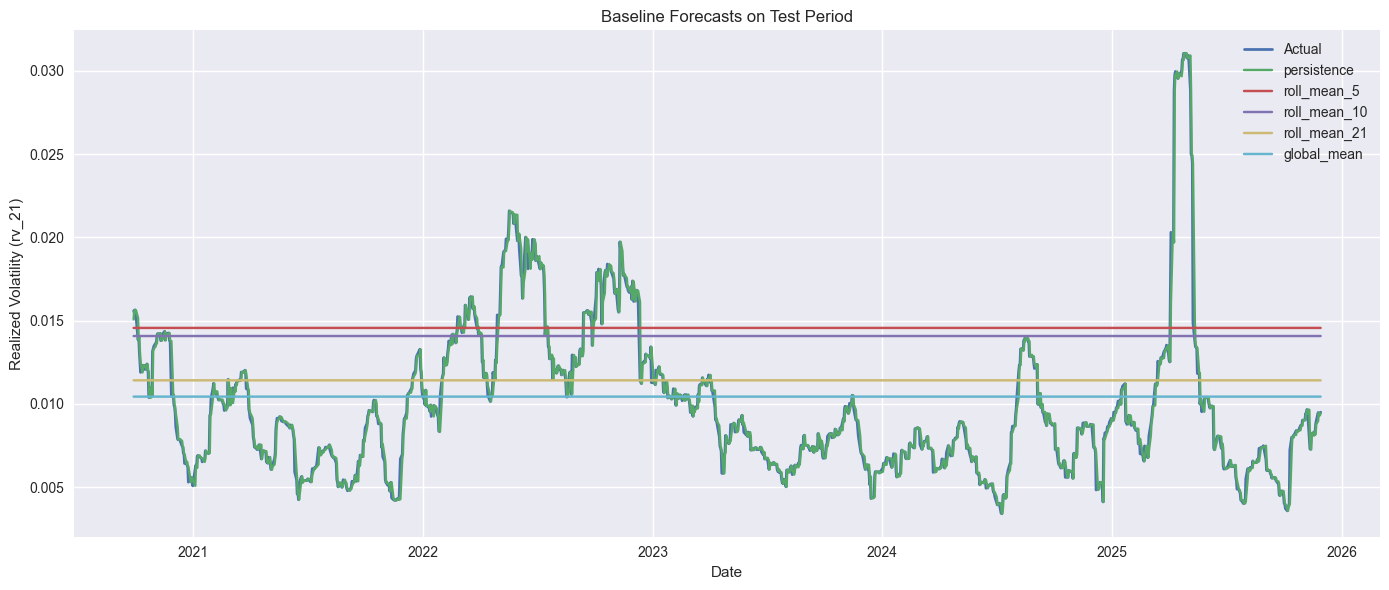

In [37]:
plt.figure(figsize=(14, 6))

plt.plot(test["Date"], y_test, label="Actual", linewidth=2)

for col in baseline_cols:
    plt.plot(test["Date"], test[col], label=col)

plt.title("Baseline Forecasts on Test Period")
plt.xlabel("Date")
plt.ylabel("Realized Volatility (rv_21)")
plt.legend()
plt.tight_layout()

fig_path = Path("../results/figures/")
fig_path.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path / "baseline_forecasts.png", dpi=200)
plt.show()


For a leak-free baseline, the final training rolling value is repeated across the test segment. The goal is not optimal forecasting but to provide a simple reference.

## **Save Outputs**
We save both the forecasts and the evaluation metrics for downstream comparison in later notebooks.

In [38]:
output_path = Path("../results/baselines/")
output_path.mkdir(parents=True, exist_ok=True)

# Save predictions
test_out = test[["Date", target_col] + baseline_cols]
test_out.to_csv(output_path / "baseline_forecasts.csv", index=False)

# Save metrics
metrics_df.to_csv(output_path / "baseline_metrics.csv", index=False)

test_out.head(), metrics_df


(           Date     rv_21  persistence  ...  roll_mean_10  roll_mean_21  global_mean
 5196 2020-09-28  0.015589     0.015075  ...      0.014079      0.011419     0.010441
 5197 2020-09-29  0.015475     0.015589  ...      0.014079      0.011419     0.010441
 5198 2020-09-30  0.015648     0.015475  ...      0.014079      0.011419     0.010441
 5199 2020-10-01  0.015589     0.015648  ...      0.014079      0.011419     0.010441
 5200 2020-10-02  0.015151     0.015589  ...      0.014079      0.011419     0.010441
 
 [5 rows x 7 columns],
           model      rmse       mae
 0   persistence  0.000698  0.000352
 1   roll_mean_5  0.006523  0.005821
 2  roll_mean_10  0.006180  0.005464
 3  roll_mean_21  0.004772  0.003876
 4   global_mean  0.004545  0.003489)

## **Conclusion**

This notebook establishes a reference set of volatility forecasts. These simple models are important for interpreting the performance of more advanced models. Future notebooks will build on this foundation with GARCH models, neural networks, and alternative volatility features.